In [1]:
from data_master import DataMaster
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime
master = DataMaster()
from scipy.stats import norm
from utils.func import *

In [2]:
universe = pd.read_parquet('data/SP500/universe_table.pq')
tickers = universe['Code'].unique()
len(tickers)

863

In [3]:
sectors = aggregate_tickers_classifs(tickers)
write_to_parquet(sectors,'SP500','GICS')

 33%|███▎      | 282/863 [02:20<04:58,  1.94it/s][DEBUG]-Starting new HTTPS connection (1): eodhistoricaldata.com:443
[DEBUG]-https://eodhistoricaldata.com:443 "GET /api/fundamentals/ES.US?api_token=640aa99a271902.64352462&filter=General HTTP/1.1" 200 None
 33%|███▎      | 283/863 [02:20<04:44,  2.04it/s][DEBUG]-Starting new HTTPS connection (1): eodhistoricaldata.com:443
[DEBUG]-https://eodhistoricaldata.com:443 "GET /api/fundamentals/ESRX.US?api_token=640aa99a271902.64352462&filter=General HTTP/1.1" 200 None
 33%|███▎      | 284/863 [02:21<04:53,  1.97it/s][DEBUG]-Starting new HTTPS connection (1): eodhistoricaldata.com:443
[DEBUG]-https://eodhistoricaldata.com:443 "GET /api/fundamentals/ESS.US?api_token=640aa99a271902.64352462&filter=General HTTP/1.1" 200 None
 33%|███▎      | 285/863 [02:21<04:45,  2.02it/s][DEBUG]-Starting new HTTPS connection (1): eodhistoricaldata.com:443
[DEBUG]-https://eodhistoricaldata.com:443 "GET /api/fundamentals/ESV.US?api_token=640aa99a271902.64352462&fi

tsmax{mult − inv[tsrankhvolatility, 5i, expmn(adv(5), 5)], 5}

In [780]:
lag = 10
market_data['mean_price']= market_data[['open','high','close']].mean(1).groupby(level=1,group_keys=False).rolling(lag).mean().droplevel(0)
num = (market_data['mean_price'] * market_data['volume']).groupby(level=1).rolling(5).sum().droplevel(0)
denom = market_data['volume'].groupby(level=1).rolling(lag).sum().droplevel(0)
vwap = num/denom
MVWAP = pd.DataFrame(vwap).unstack().rolling(lag).mean().droplevel(0,axis=1).reindex_like(P)
MVWAP
MVWAP_min = MVWAP.apply(lambda x : x.rolling(lag).min())



In [781]:
lag = 5
market_data['mean_price']= market_data[['open','high']].mean(1)
vwap = market_data['mean_price']
MVWAP = pd.DataFrame(vwap).unstack().rolling(lag).mean().droplevel(0,axis=1).reindex_like(P)
MVWAP
MVWAP_min = MVWAP.apply(lambda x : x.rolling(lag).min())



In [14]:
a = master.equities.get_ticker_classification('AAPL','US')
a

{'sector': 'Technology',
 'industry': 'Consumer Electronics',
 'gicsect': 'Information Technology',
 'gicgrp': 'Technology Hardware & Equipment',
 'gicind': 'Technology Hardware, Storage & Peripherals',
 'gicsubind': 'Technology Hardware, Storage & Peripherals'}

In [ ]:
# sectors = pd.read_parquet('sectors_sp500.pq')
# sectors = sectors[sectors.index.isin(SIGNAL.columns)]
# sectors.index.names = ['Ticker']
# market_data = market_data.join(sectors[['sector']])
# market_data = market_data.join(sectors['gicgrp'])
GICS = market_data['gicgrp'].unstack().reindex_like(P).fillna('Other')

In [ ]:
SIGNAL = (MVWAP_min - MVWAP).ffill()[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
SIGNAL[SIGNAL.abs()<0.25] = None


In [ ]:
for gics in GICS.stack().unique():
    SIGNAL[GICS == gics]= SIGNAL[GICS == gics].sub(SIGNAL[GICS==gics].mean(1),0)

In [ ]:
SIGNAL= SIGNAL.div(SIGNAL.abs().sum(1),0)


In [ ]:
SIGNAL.sum(1).plot()
SIGNAL.abs().sum(1).plot()

In [ ]:

pnl = (SIGNAL.shift() *R).sum(1).loc['2023-01']
pnl.cumsum().plot()
print((pnl.mean()* np.sqrt(252)/ pnl.std()))

In [ ]:
b = master.equities.get_ticker_financials('AAPL','US')

In [ ]:
balance_sheets = {}
missed = []
for ticker in universe_table['Code'].unique():
    try :
        balance_sheets[ticker] = master.equities.get_ticker_balance_sheet(ticker,'US')
    except :
        missed = missed +[ticker]

In [ ]:
data = pd.concat(balance_sheets)

In [ ]:
data.index.names =['Code','datetime']
data = data.reorder_levels(['datetime','Code'])
data.to_parquet('balance_sheets_sp500.pq')

In [ ]:
data_us = data[data['currency_symbol']=='USD']
data_us['quarter'] = pd.to_datetime

In [ ]:
lag = [2,5,7,10,15,20,30,40,50,60]
thresholds = np.arange(0,1,step =0.05)
result = pd.DataFrame(index = lag,columns = thresholds)
result

In [988]:
metrics = (-data_us['netDebt'].astype(float)/data_us['cash'].astype(float))
netdebt = metrics.unstack().ffill()
netdebt = netdebt.rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
netdebt.index = pd.to_datetime(netdebt.index)
netdebt = netdebt.stack().groupby(level=1).rolling(10).rank(pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf).droplevel(0)
netdebt = netdebt.unstack().reindex_like(P).ffill()
netdebt.stack()


datetime    Code
2005-01-31  A       0.674490
            AAL    -0.125661
            AAP     1.281552
            AAPL    0.524401
            ABC    -0.841621
                      ...   
2023-03-10  YUM    -1.281552
            ZBH     0.000000
            ZBRA    0.674490
            ZION    0.125661
            ZTS     1.036433
Length: 2835584, dtype: float64

In [989]:
# market_data = market_data.join(sectors['gicsect'])
GICS = market_data['gicsect'].unstack().reindex_like(P).fillna('Other')

In [1117]:
thresh =0.3
GICS = market_data['gicsect'].unstack().reindex_like(P).fillna('Other')
SIGNAL = netdebt.copy()
SIGNAL = SIGNAL[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
SIGNAL[SIGNAL.abs()<thresh] = None
for gics in GICS.stack().unique():
    SIGNAL[GICS == gics]= SIGNAL[GICS == gics].sub(SIGNAL[GICS==gics].mean(1),0)
# SIGNAL = SIGNAL.sub(SIGNAL.mean(1),0)
SIGNAL= SIGNAL.div(SIGNAL.abs().sum(1),0)


KeyError: 'gicsect'

50 0.7 0.09977791472934536


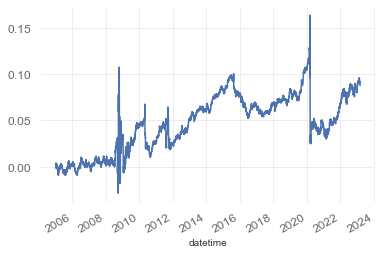

In [1116]:
pnl = (SIGNAL.shift(1) *R).sum(1).replace({0:np.nan}).dropna()
sharpe = (pnl.mean(skipna=True)* np.sqrt(252)/ pnl.std(skipna=True))
print(delta,thresh,sharpe)
pnl.cumsum().plot()
plt.show()

In [1006]:
SIGNAL_1 = pd.DataFrame((market_data['high']+market_data['low'])/2 - market_data['close'],columns =['SIGNAL_1'])

SIGNAL_2 = market_data['low']/market_data['adj_close']
SIGNAL_2 = pd.DataFrame(SIGNAL_2  - SIGNAL_2.groupby(level=1).shift(5),columns =['SIGNAL_2'])
# SIGNAL = SIGNAL_1 + SIGNAL_2
SIGNAL = SIGNAL_2.ffill().join(SIGNAL_1.ffill()).sum(1).unstack().ffill()
SIGNAL

In [1042]:
thresh =0.0
GICS = market_data['gicsect'].unstack().reindex_like(P).fillna('Other')
SIGNAL = SIGNAL = SIGNAL_2.ffill().join(SIGNAL_1.ffill()).sum(1).unstack().ffill()
SIGNAL = SIGNAL[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
# SIGNAL[SIGNAL.abs()<thresh] = None
# for gics in GICS.stack().unique():
#     SIGNAL[GICS == gics]= SIGNAL[GICS == gics].sub(SIGNAL[GICS==gics].mean(1),0)
SIGNAL = SIGNAL[P].sub(SIGNAL[P].mean(1),0)
SIGNAL= SIGNAL[P].div(SIGNAL[P].abs().sum(1),0)


3.0540185978078838


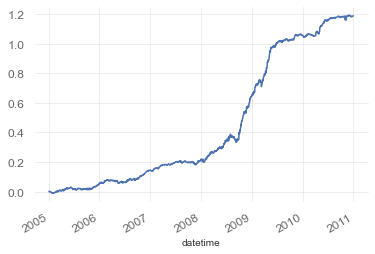

In [1043]:
pnl = (SIGNAL[P].shift(1) *R).sum(1).loc[:'2010'].dropna()
sharpe = (pnl.mean(skipna=True)* np.sqrt(252)/ pnl.std(skipna=True))
print(sharpe)
pnl.cumsum().plot()
plt.show()

<Axes: xlabel='datetime'>

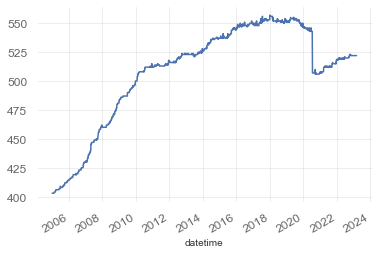

In [1044]:
SIGNAL.count(1).plot()

<Axes: xlabel='datetime'>

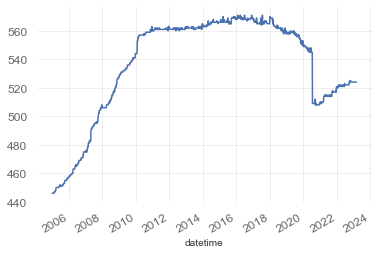

In [1047]:
(P*1).sum(1).plot()

In [1052]:
universe_table_r1K = master.baskets.get_index_components('RUI')
universe_table_r1K
codes_R1K= universe_table_r1K['Code'].unique()
data_R1K = {}
for ticker in tqdm(codes_R1K):
    try :
        df_ticker = master.equities.get_ohlcv(ticker,'US',period_start=datetime.date(2005,1,1))
        data_R1K[ticker] =df_ticker
    except :
        ''

[DEBUG]-Starting new HTTPS connection (1): eodhistoricaldata.com:443
[DEBUG]-https://eodhistoricaldata.com:443 "GET /api/fundamentals/RUI.INDX?fmt=json&api_token=640aa99a271902.64352462 HTTP/1.1" 200 None
  0%|          | 0/1010 [00:00<?, ?it/s][DEBUG]-Starting new HTTPS connection (1): eodhistoricaldata.com:443
[DEBUG]-https://eodhistoricaldata.com:443 "GET /api/fundamentals/AIZ.US?api_token=640aa99a271902.64352462&filter=General HTTP/1.1" 200 None
[DEBUG]-Starting new HTTPS connection (1): eodhistoricaldata.com:443
[DEBUG]-https://eodhistoricaldata.com:443 "GET /api/eod/AIZ.US?api_token=640aa99a271902.64352462&fmt=json&from=2005-01-01&to=2023-03-11 HTTP/1.1" 200 None
[INFO]-successful get_ohlcv but not inserted AIZ
  0%|          | 1/1010 [00:01<24:17,  1.44s/it][DEBUG]-Starting new HTTPS connection (1): eodhistoricaldata.com:443
[DEBUG]-https://eodhistoricaldata.com:443 "GET /api/fundamentals/AL.US?api_token=640aa99a271902.64352462&filter=General HTTP/1.1" 200 None
[DEBUG]-Starting 

In [1067]:
market_data_R1K = pd.concat(data_R1K,axis=0)
market_data_R1K = market_data_R1K.droplevel(1).set_index(['datetime'],append=True)
market_data_R1K.index.names =['Ticker','datetime']
market_data_R1K = market_data_R1K.reorder_levels(['datetime','Ticker'])
market_data_R1K.to_parquet('r1K_mkt_data.pq')

In [1069]:
SIGNAL_1 = pd.DataFrame((market_data['high']+market_data['low'])/2 - market_data['close'],columns =['SIGNAL_1'])

SIGNAL_2 = market_data['low']/market_data['adj_close']
SIGNAL_2 = pd.DataFrame(SIGNAL_2  - SIGNAL_2.groupby(level=1).shift(5),columns =['SIGNAL_2'])
# SIGNAL = SIGNAL_1 + SIGNAL_2
SIGNAL = SIGNAL_2.ffill().join(SIGNAL_1.ffill()).sum(1).unstack().ffill()
SIGNAL

Ticker,A,AA,AABA,AAL,AAP,AAPL,ABBV,ABC,ABK,ABMD,...,XRAY,XRX,XTO,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZTS
datetime,,,,,,,,,,,,,,,,,,,,,
2005-01-03,-0.016634,0.358908,0.085808,NaN,0.363505,0.563774,NaN,0.237600,-0.104344,0.459624,...,0.041614,-0.027254,0.593445,NaN,0.102030,0.159859,0.780817,0.489558,0.325209,NaN
2005-01-04,0.275316,0.178958,0.910808,NaN,0.138505,0.278174,NaN,0.097000,0.730656,-0.000376,...,0.746614,0.052746,0.221445,NaN,0.927030,0.328859,0.373617,0.379558,0.500209,NaN
2005-01-05,0.157566,-0.026192,0.380808,NaN,0.188505,0.146574,NaN,0.024300,-0.249344,-0.035376,...,0.361614,0.187746,0.295945,NaN,0.397030,0.127509,0.649867,0.739558,0.360209,NaN
2005-01-06,0.336566,0.188908,0.415808,NaN,0.193505,-0.433026,NaN,-0.053300,0.095656,0.007424,...,0.031614,0.082746,-0.004055,NaN,0.432030,-0.242791,-0.164383,0.184558,-0.099791,NaN
2005-01-07,0.096316,-0.001092,-0.034192,NaN,0.343505,-2.059826,NaN,-0.140800,0.500656,-0.140376,...,0.246614,0.147746,-0.001055,NaN,-0.017970,0.030359,0.184567,-0.045442,0.625209,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-06,0.828762,0.477248,-0.091092,0.208878,2.055425,1.050772,0.222883,-0.704993,0.000000,0.000656,...,-0.048403,0.143260,0.487746,0.519506,0.013732,0.182530,0.564717,3.098565,0.509762,1.132606
2023-03-07,1.618373,1.326549,-0.091092,0.054713,0.779580,0.980834,0.932563,1.924555,0.000000,0.000656,...,0.456838,0.119837,0.487746,0.626250,0.013732,1.471367,0.957244,1.840893,0.727825,1.850539
2023-03-08,-0.421625,-0.529972,-0.091092,-0.156821,0.033505,-0.224739,1.551592,0.279418,0.000000,0.000656,...,0.284876,0.009752,0.487746,-0.026570,0.013732,-0.324330,0.504138,-2.641860,0.148172,-0.726896


In [1074]:
universe_table_r1K = master.baskets.get_index_components('RUI')
universe_table_r1K=  universe_table_r1K.set_index('Code')
universe_table_r1K.index.names =['Ticker']
market_data_R1K = market_data_R1K.join(universe_table_r1K[['Sector','Industry']])
market_data_R1K

[DEBUG]-Starting new HTTPS connection (1): eodhistoricaldata.com:443
[DEBUG]-https://eodhistoricaldata.com:443 "GET /api/fundamentals/RUI.INDX?fmt=json&api_token=640aa99a271902.64352462 HTTP/1.1" 200 None


,,open,high,low,close,adj_close,volume,Sector,Industry
datetime,Ticker,,,,,,,,
2005-01-03,AIZ,30.60,30.950,30.550,30.70,22.0995,731200,Financial Services,Insurance-Specialty
2005-01-04,AIZ,30.00,30.130,29.800,30.10,21.6675,1433500,Financial Services,Insurance-Specialty
2005-01-05,AIZ,30.05,30.060,29.700,29.85,21.4876,534700,Financial Services,Insurance-Specialty
2005-01-06,AIZ,29.85,30.950,29.800,30.60,22.0275,1438700,Financial Services,Insurance-Specialty
2005-01-07,AIZ,30.58,30.800,30.250,30.38,21.8691,200700,Financial Services,Insurance-Specialty
...,...,...,...,...,...,...,...,...,...
2023-03-06,ADT,7.68,7.880,7.675,7.72,7.7200,3883800,Industrials,Security & Protection Services
2023-03-07,ADT,7.72,7.820,7.570,7.62,7.6200,2691500,Industrials,Security & Protection Services
2023-03-08,ADT,7.62,7.800,7.595,7.78,7.7800,2579200,Industrials,Security & Protection Services


In [1088]:
MVWAP = (market_data_R1K["close"] * market_data['volume']).groupby(level=1).rolling(5).mean()
MVWAP

Ticker  datetime    Ticker
A       2005-01-03  A                  NaN
        2005-01-04  A                  NaN
        2005-01-05  A                  NaN
        2005-01-06  A                  NaN
        2005-01-07  A         5.252894e+07
                                  ...     
ZTS     2023-03-06  ZTS       3.129150e+08
        2023-03-07  ZTS       2.578929e+08
        2023-03-08  ZTS       2.368471e+08
        2023-03-09  ZTS       2.338438e+08
        2023-03-10  ZTS       2.845535e+08
Length: 4544441, dtype: float64

In [1093]:
MVWAP_min = MVWAP.droplevel(0).groupby(level=1).rolling(5).min()
MVWAP = MVWAP.droplevel(0)

In [1096]:
VWAP = (market_data_R1K['adj_close']* market_data_R1K['volume']).groupby(level=0).rolling(5).mean()
VOLUME =  market_data_R1K['volume'].groupby(level=0).rolling(5).mean()
VWAP

datetime    Ticker
2005-01-03  A                  NaN
2005-01-04  A                  NaN
2005-01-05  A                  NaN
2005-01-06  A                  NaN
2005-01-07  A         5.252894e+07
                          ...     
2023-03-06  ZTS       3.129150e+08
2023-03-07  ZTS       2.578929e+08
2023-03-08  ZTS       2.368471e+08
2023-03-09  ZTS       2.338438e+08
2023-03-10  ZTS       2.845535e+08
Length: 4544441, dtype: float64

In [1103]:
ALPHA = (VWAP.droplevel(0)/VOLUME.droplevel(0))
ALPHA_MIN = ALPHA.groupby(level=1).rolling(5).min().droplevel(0)
ALPHA_MIN
SIGQL = A

datetime    Ticker
2005-01-03  A                NaN
2005-01-04  A                NaN
2005-01-05  A                NaN
2005-01-06  A                NaN
2005-01-07  A          14.788687
                         ...    
2023-03-06  ZTS        89.834714
2023-03-07  ZTS        89.834714
2023-03-08  ZTS       100.196084
2023-03-09  ZTS       102.028800
2023-03-10  ZTS       102.028800
Length: 3701529, dtype: float64

In [1104]:
thresh =0.7
GICS = market_data_R1K['Sector'].unstack().reindex_like(P).fillna('Other')
SIGNAL =(ALPHA_MIN - ALPHA).unstack().ffill()
SIGNAL = SIGNAL.rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
SIGNAL[SIGNAL.abs()<thresh] = None
for gics in GICS.stack().unique():
    SIGNAL[GICS == gics]= SIGNAL[GICS == gics].sub(SIGNAL[GICS==gics].mean(1),0)
# SIGNAL = SIGNAL.sub(SIGNAL.mean(1),0)
SIGNAL= SIGNAL.div(SIGNAL.abs().sum(1),0)


<Axes: xlabel='datetime'>

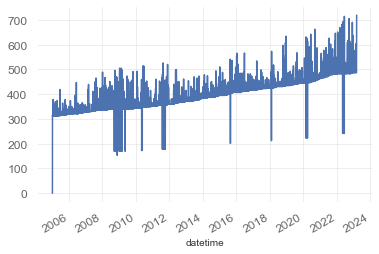

In [1106]:
SIGNAL.count(1).plot()

0.08399456571262236


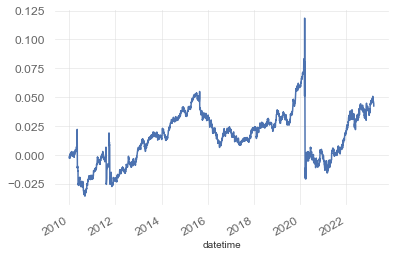

In [1107]:
R = market_data_R1K['adj_close'].unstack().pct_change()
pnl = (SIGNAL.shift(1) *R).sum(1).loc['2010':].dropna()
sharpe = (pnl.mean(skipna=True)* np.sqrt(252)/ pnl.std(skipna=True))
print(sharpe)
pnl.cumsum().plot()
plt.show()

In [1078]:
sharpe

nan